# Model Fine-tuning Notebook
The purpose of this notebook is exploring and fine-tuning the short listed candidate models to get our best model. In the flow, this notebook covers from step 12 and on.

## Importing Packages

In [279]:
import sys
import time
from pathlib import Path
import os

import pandas as pd
import numpy as np

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import TargetEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.metrics import root_mean_squared_error

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import StackingRegressor

from sklearn.model_selection import KFold

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from scipy.stats import randint
from scipy.stats import uniform
import matplotlib.pyplot as plt
import seaborn as sns

## Setting up for imports of .py modules

In [280]:
path = Path(os.getcwd())
path = str(path)
print(path)
sys.path.insert(1, path)

/Users/lwillans/PycharmProjects/DS5220_Final/DS5220-Supervised-ML-Project


## Importing python modules

In [281]:
import utils.sml_utils as sml_utils
import utils.regression_utils as reg_utils
import utils.all_attr_eda_utils as aae_utils

## Parameters

In [282]:
path_to_data = 'data/winequality-white.csv'
target_attr = 'quality'
test_size = 0.20
train_test_split_random_state = 42
missingness_threshold = 0.20

# step 9
elastic_net_random_state = 42
decision_tree_random_state = 42
random_forest_random_state = 42
gradient_boosting_random_state = 42
target_encoder_random_state = 42

# step 10
scoring = ['neg_root_mean_squared_error', 'neg_mean_absolute_error', 'max_error', 'r2']
kwargs = {'return_indices': False}  # if true the indices of the cross validation split are returned
max_iter = 10000  # max number of iterations for Lasso, Ridge and ElasticNet - default was 1000
kfold_n_splits = 10  # number of folds in k-fold cv
kfold_shuffle = True
kfold_random_state = 42

# step 12
gs_cv_kfold_n_splits = 10
gs_cv_kfold_shuffle = True
gs_cv_kfold_random_state = 24
show_all_params = False

## Dataset variables (train/test dataframes were created in previous phases)

In [283]:
train_df = pd.read_csv('data/wine_train_df.csv').copy() # Make copy so original is not affected
train_cap_x_df = train_df.iloc[:, :-1]  # All columns except the last one
train_y_df = train_df.iloc[:, -1].to_frame()

## Set up time

In [284]:
start = time.time()

## 1. Checking missingness (also done in previous phases)

In [285]:
# print(df.shape)
# df = df.dropna(subset=target_attr)
# print(df.shape)

## 2. Train/Test data split (already done in previous phases)

`wine_train_df` and `wine_test_df` were already created back in phase 1

In [286]:
wine_train_df = pd.read_csv('data/wine_train_df.csv', sep=",")
wine_test_df = pd.read_csv('data/wine_test_df.csv', sep=",")
print(f"wine_train_df shape: {wine_train_df.shape}")
print(f"wine_test_df shape: {wine_test_df.shape}")
del wine_train_df
del wine_test_df

wine_train_df shape: (3918, 12)
wine_test_df shape: (980, 12)


## 3. Train/Validation split

This step will be omitted because cross-validation will be used to select models


## 4. Checking out attribute types
Already completed in previous notebooks.

## 5. Identifying attributes with missingness above threshold
Already completed in previous notebooks.

In [287]:
return_dict = sml_utils.get_missingness(train_cap_x_df, missingness_threshold)
missingness_drop_list = return_dict['missingness_drop_list']

fixed acidity missingness = 0.0
volatile acidity missingness = 0.0
citric acid missingness = 0.0
residual sugar missingness = 0.0
chlorides missingness = 0.0
free sulfur dioxide missingness = 0.0
total sulfur dioxide missingness = 0.0
density missingness = 0.0
pH missingness = 0.0
sulphates missingness = 0.0
alcohol missingness = 0.0

missingness_drop_list:
[]


## 6. Identifying non machine learning attributes
Already completed in previous notebooks.

In [288]:
non_ml_attr_list = [] # no non-machine learning attributes were identified

## 7. Looking at attributes to exclude from ML
Dropping based on Lasso completed in model_exp_x.ipynb (Step V)

In [289]:
ml_attr_drop_list = ['fixed_acidity', 'volatile_acidity', 'citric_acid', 'chlorides', 'density', 'pH', 'sulphates']

## 8. Establishing ML attribute configuration
Already completed in previous notebooks.

In [290]:
ml_ignore_list = missingness_drop_list + non_ml_attr_list + ml_attr_drop_list
ml_ignore_list

['fixed_acidity',
 'volatile_acidity',
 'citric_acid',
 'chlorides',
 'density',
 'pH',
 'sulphates']

In [291]:
# Identifying the remaining numerical attributes to be used

numerical_attr = ['residual sugar', 'free sulfur dioxide', 'total sulfur dioxide', 'alcohol',]

# Identifying the remaining nominal attributes to be used

nominal_attr = [] 

assert(train_cap_x_df.shape[1] == len(ml_ignore_list) + len(nominal_attr) + len(numerical_attr))

print(f'ml_ignore_list: {ml_ignore_list}')
print(f'\nnumerical_attr: {numerical_attr}')
print(f'nominal_attr: {nominal_attr}')

print(f'\nnumber of machine learning attributes: {len(numerical_attr) + len(nominal_attr)}')
print(f'\nnumerical_attr and nominal_attr: {numerical_attr + nominal_attr}')

ml_ignore_list: ['fixed_acidity', 'volatile_acidity', 'citric_acid', 'chlorides', 'density', 'pH', 'sulphates']

numerical_attr: ['residual sugar', 'free sulfur dioxide', 'total sulfur dioxide', 'alcohol']
nominal_attr: []

number of machine learning attributes: 4

numerical_attr and nominal_attr: ['residual sugar', 'free sulfur dioxide', 'total sulfur dioxide', 'alcohol']


## 9. Building the composite estimators
Shortlist already created in `model_exp_x.ipynb`

In [292]:
estimator_dict = {
    'LinearRegression': LinearRegression(
        fit_intercept=True,
        copy_X=True,
        n_jobs=None,
        positive=False
    ),

    'ElasticNet': ElasticNet(
        fit_intercept=True,
        copy_X=True,
        positive=False,

        alpha=1.0,
        l1_ratio=0.5,
        max_iter=max_iter,
        tol=0.0001,
        selection='cyclic',

        precompute=False,
        warm_start=False,
        random_state=elastic_net_random_state,
    ),

    'DecisionTreeRegressor': DecisionTreeRegressor(
        criterion='squared_error',
        splitter='best',
        max_depth=None,
        min_samples_split=2,
        min_samples_leaf=1,
        min_weight_fraction_leaf=0.0,
        max_features=None,
        random_state=decision_tree_random_state,
        max_leaf_nodes=None,
        min_impurity_decrease=0.0,
        ccp_alpha=0.0,
        monotonic_cst=None
    ),

    'RandomForestRegressor': RandomForestRegressor(
        
        n_estimators=100,
        bootstrap=True, 
        oob_score=False, 
        n_jobs=None,
        verbose=0, 
        warm_start=False,
        max_samples=None, 
        
        criterion='squared_error',  # in DecisionTreeRegressor
        max_depth=None,
        min_samples_split=2,
        min_samples_leaf=1,
        min_weight_fraction_leaf=0.0,
        max_features=1.0,
        max_leaf_nodes=None,
        min_impurity_decrease=0.0,
        random_state=random_forest_random_state,
        ccp_alpha=0.0,
        monotonic_cst=None
    ),

    'GradientBoostingRegressor': GradientBoostingRegressor(
        
        n_estimators=100, 
        learning_rate=0.1,
        validation_fraction=0.1,  # proportion of training data to set aside as validation set for early stopping
        n_iter_no_change=None,  # used to decide if early stopping will be used to terminate training
        tol=0.0001,  # tolerance for early stopping
        subsample=1.0,  # fraction of samples to be used for fitting the individual base learners
        criterion='friedman_mse',  # what measures quality of split

        loss='squared_error',  # in DecisionTreeRegressor
        max_depth=3,
        min_samples_split=2,
        min_samples_leaf=1,
        min_weight_fraction_leaf=0.0,
        max_features=None,
        max_leaf_nodes=None,
        min_impurity_decrease=0.0,
        random_state=gradient_boosting_random_state,
        ccp_alpha=0.0,
        
        init=None, 
        alpha=0.9, 
        verbose=0, 
        warm_start=False
        
    )

}

### preprocessing pipeline (already done in `model_exp_x.ipynb`)

In [293]:
numerical_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer()),
        ("scaler", StandardScaler())
    ]
)
# discretizer not needed

In [294]:
# Not used as there are no nominal attributes
nominal_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy='most_frequent')),
        ("ohe", OneHotEncoder())
    ]
)

In [295]:
preprocessor = ColumnTransformer(
        transformers=[
            ('nominal', nominal_transformer, nominal_attr),
            ('numerical', numerical_transformer, numerical_attr)
        ]
)

In [296]:
composite_estimator = Pipeline(steps=[('preprocessor', preprocessor), ('estimator', estimator_dict)])

### output of preprocessing step

In [297]:
trans_train_cap_x_df = pd.DataFrame(
    data=composite_estimator[0].fit_transform(train_cap_x_df),
    index=train_cap_x_df.index,
    columns=[attr_name for attr_name in composite_estimator[0].get_feature_names_out()]
)
trans_train_cap_x_df.head()

,numerical__residual sugar,numerical__free sulfur dioxide,numerical__total sulfur dioxide,numerical__alcohol
0,0.340419,0.534065,-0.641932,1.540371
1,1.002071,0.773947,1.355106,-0.821712
2,0.184737,-0.605377,-1.022320,0.481506
3,-0.924503,-0.125612,-0.879675,0.237153
4,2.432407,0.054300,0.855846,-0.088652


## 10. Fitting/evaluating composite estimators
### Surveying the candidate default models by fitting them on the whole train set
This was already completed in `model_exp_x.ipynb`

In [298]:
return_dict = sml_utils.model_survey_fit(preprocessor, estimator_dict, train_cap_x_df, train_y_df)
trained_estimator_dict = return_dict['trained_estimator_dict']

LinearRegression
ElasticNet
DecisionTreeRegressor
RandomForestRegressor
GradientBoostingRegressor


### Estimating the test error rate using k-fold cv (using KFold splitter), mean and standard deviation caclculated in part V


                regressor_name              score_name_ score_type     score
0       DecisionTreeRegressor                max_error       test  3.500000
1       DecisionTreeRegressor                max_error      train  0.250000
2       DecisionTreeRegressor      mean_absolute_error       test  0.536901
3       DecisionTreeRegressor      mean_absolute_error      train  0.000189
4       DecisionTreeRegressor                       r2       test -0.013625
5       DecisionTreeRegressor                       r2      train  0.999840
6       DecisionTreeRegressor  root_mean_squared_error       test  0.889937
7       DecisionTreeRegressor  root_mean_squared_error      train  0.007938
8                  ElasticNet                max_error       test  2.872611
9                  ElasticNet                max_error      train  3.128637
10                 ElasticNet      mean_absolute_error       test  0.672736
11                 ElasticNet      mean_absolute_error      train  0.672418
12        

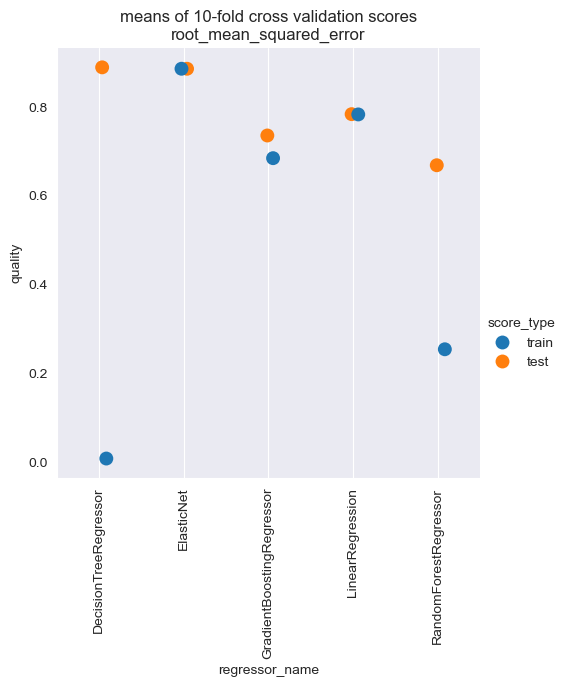

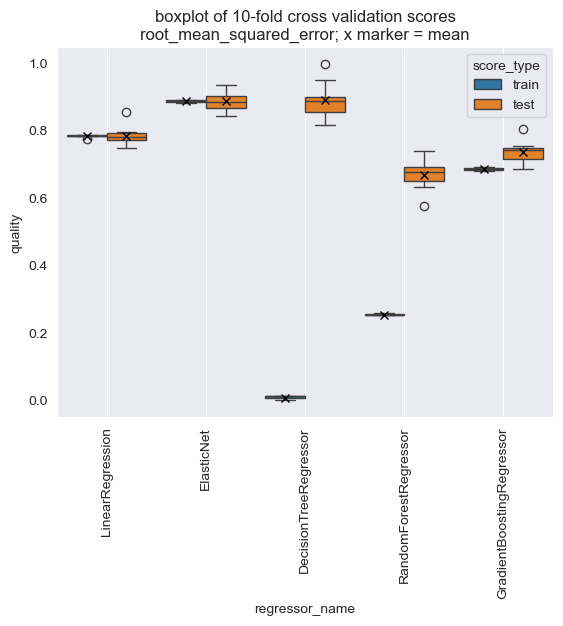

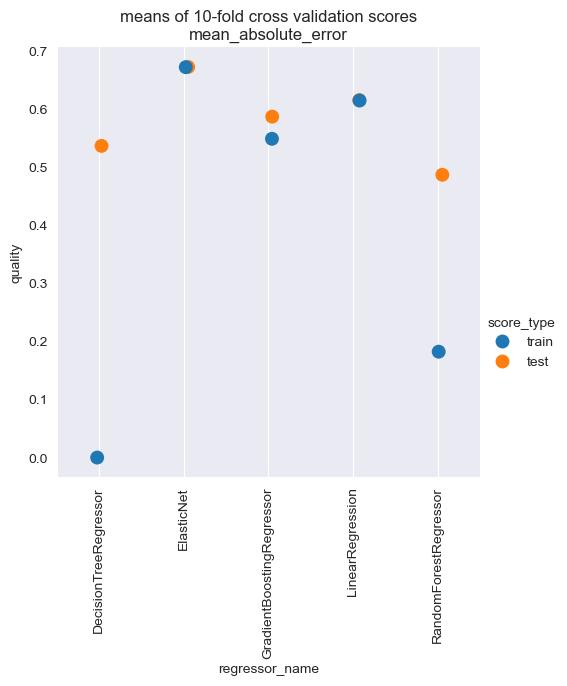

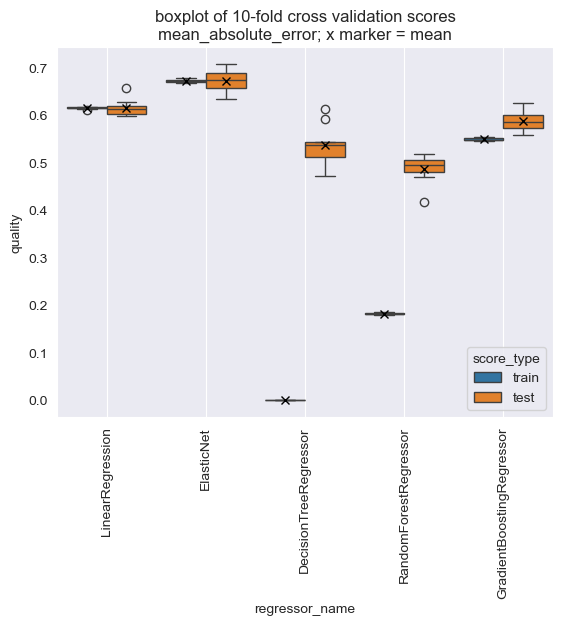

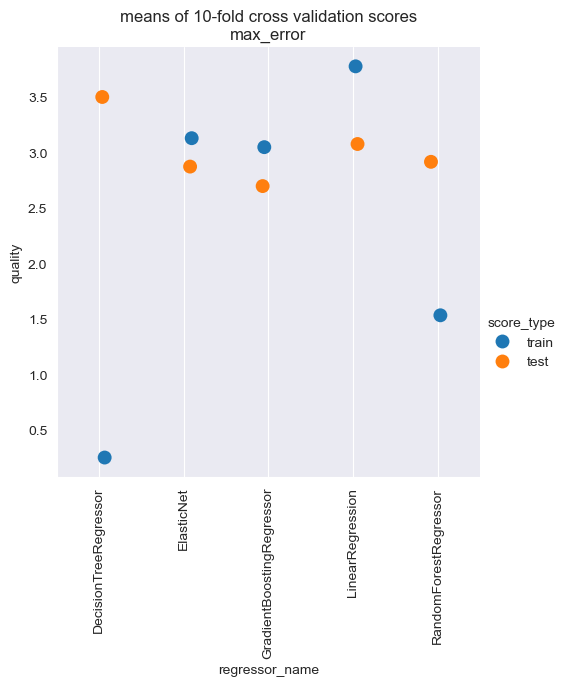

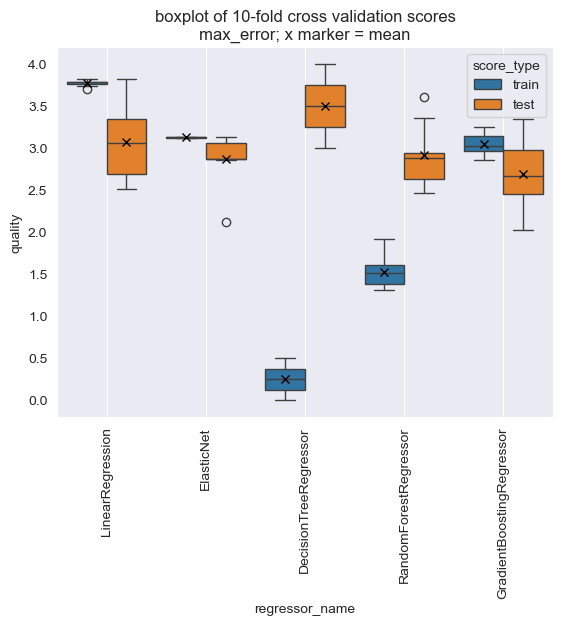

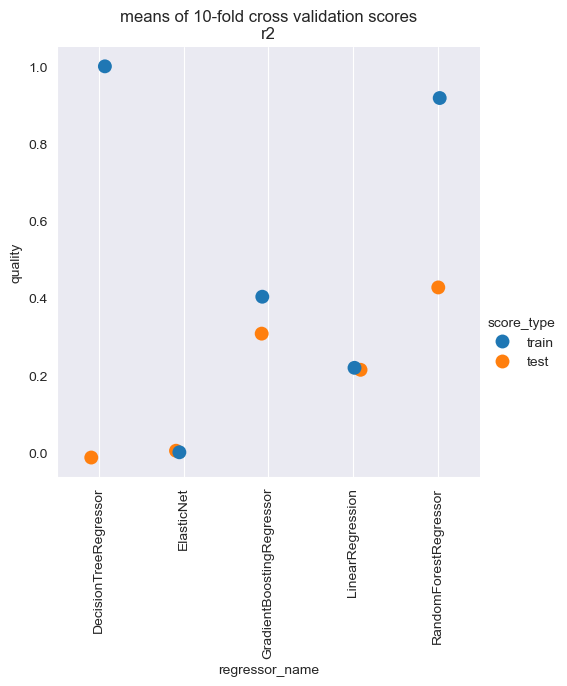

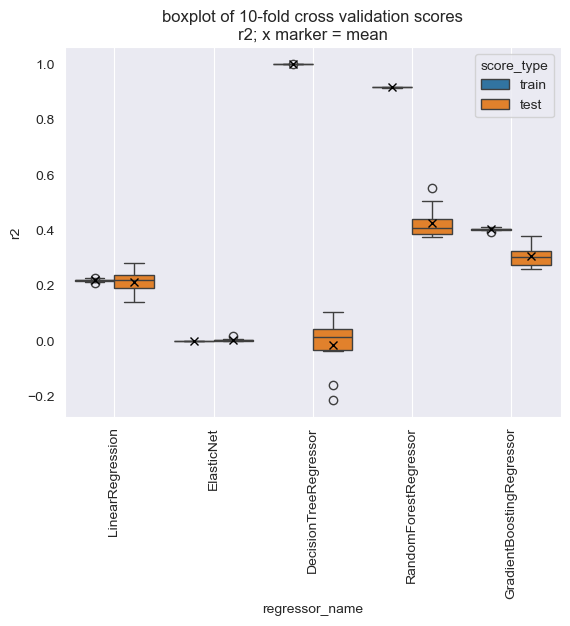

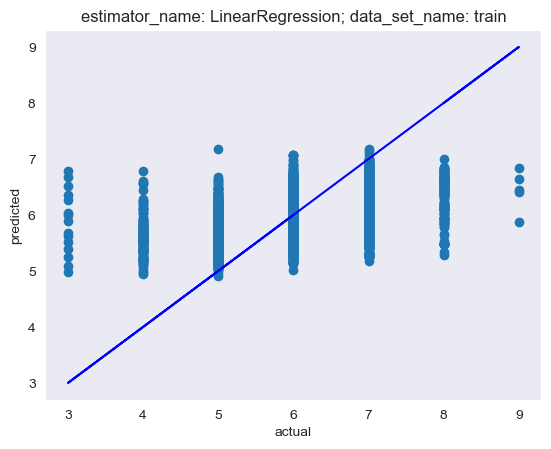

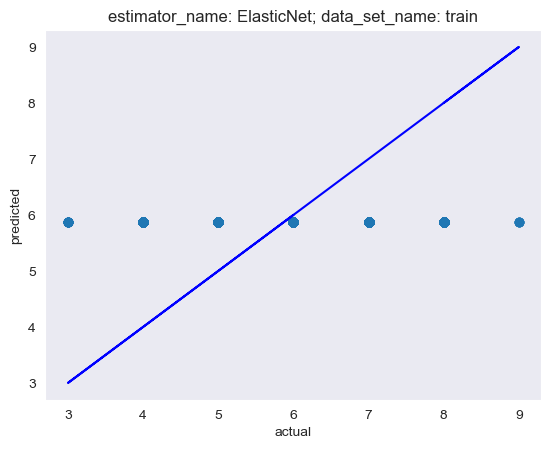

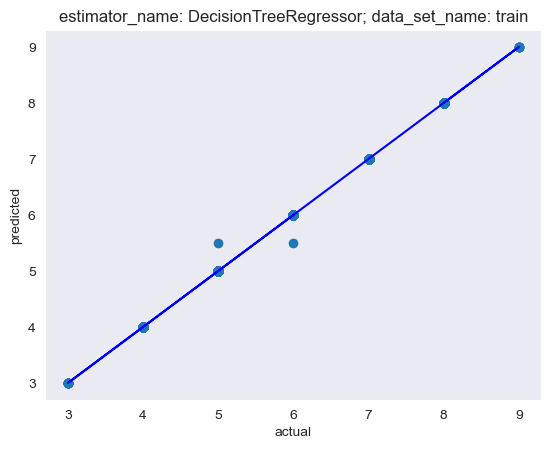

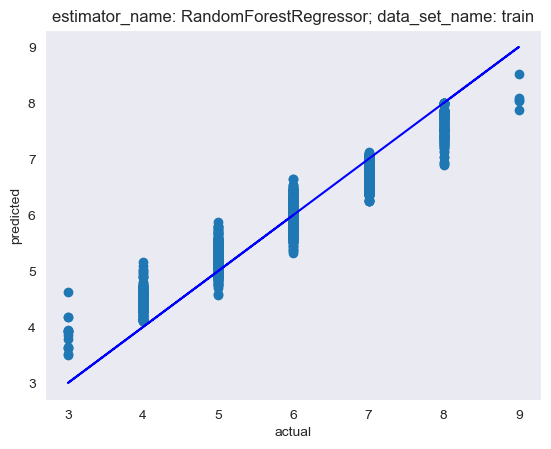

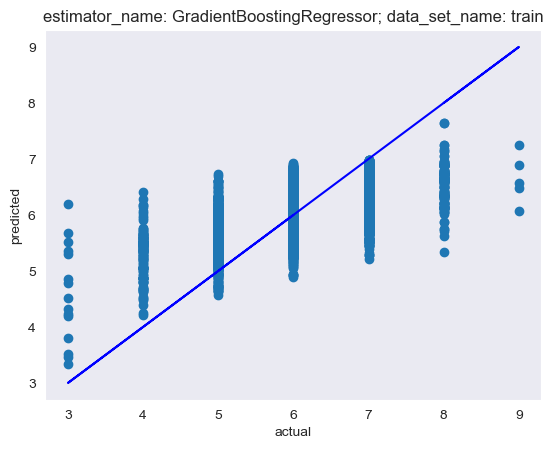

In [299]:
# get the maximal control k-fold cross validation splitter
splitter = KFold(n_splits=kfold_n_splits, 
                 shuffle=kfold_shuffle, 
                 random_state=kfold_random_state
)

# perform cross validation on models
sml_utils.model_survey_cross_val_and_analysis(preprocessor, estimator_dict, train_cap_x_df, train_y_df, scoring, splitter, target_attr, trained_estimator_dict, **kwargs)

## 11. Shortlisting default models
The shortlist was chosen in `model_exp_x.ipynb`

In [300]:
estimator_dict.keys()

dict_keys(['LinearRegression', 'ElasticNet', 'DecisionTreeRegressor', 'RandomForestRegressor', 'GradientBoostingRegressor'])

In [301]:
to_remove = ['DecisionTreeRegressor', 'ElasticNet']
for key in to_remove:
    del estimator_dict[key]

estimator_dict

{'LinearRegression': LinearRegression(),
 'RandomForestRegressor': RandomForestRegressor(random_state=42),
 'GradientBoostingRegressor': GradientBoostingRegressor(random_state=42)}

## 12. Tuning hyperparameters of shortlisted models

### numpy logspace function

In [302]:
list(np.logspace(-1.1, -0.7, num=5)) # ADJUST THIS AS NEEDED

[0.07943282347242814,
 0.1,
 0.12589254117941673,
 0.15848931924611134,
 0.19952623149688797]

### numpy arange function

In [303]:
list(np.arange(0.7, 1.0, step=0.1).round(2)) # ADJUST THIS AS NEEDED

[0.7, 0.8, 0.9, 1.0]

### Setting up hyperparameter space for grid search

In [304]:
linear_regression_param_grid = {

}

random_forest_param_grid = {
    
    'estimator__n_estimators': randint(low=1, high=200),  # default 100
    'estimator__max_samples': randint(low=1, high=1000), # default value None
    'estimator__max_depth': randint(low=1, high=200),  # default value None
    'estimator__min_samples_split': randint(low=2, high=200),  # default value 2
    'estimator__min_samples_leaf': randint(low=1, high=200), # default value 1
    'estimator__max_leaf_nodes': randint(low=2, high=200),  # default value None
    
}

gradient_boosting_param_grid = {

    'estimator__n_estimators': randint(low=1, high=200),  # default value 100

    # early stopping
    'estimator__n_iter_no_change': randint(low=1, high=2000),  # default value None

    # regularization
    'estimator__learning_rate': uniform(0,0.2),  # default value 0.1
    'estimator__max_depth': randint(low=1, high=20),  # default value 3
    'estimator__subsample': uniform(0,1),  # default value 1.0
    'estimator__max_features': randint(low=1, high=200)  # default value None
    
}

param_grids = {
    'RandomForestRegressor': random_forest_param_grid,
    'GradientBoostingRegressor': gradient_boosting_param_grid,
    'LinearRegression': linear_regression_param_grid # No Parameters to test
}


### Performing random search cross validation
RandomizedSearchCV is being used as required based on project description powerpoint. Just to note, no parameter adjustments for Linear Regression, hence the warning.

In [305]:
# get the maximal control k-fold cross validation splitter
splitter = KFold(n_splits=gs_cv_kfold_n_splits, 
                 shuffle=gs_cv_kfold_shuffle, 
                 random_state=gs_cv_kfold_random_state
)

# collect grid seach cv results here
tuned_estimator_dict = {}

for estimator_name, estimator in estimator_dict.items():
    
    print(estimator_name)

    composite_estimator = \
    Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('estimator', estimator)
        ]
    )
    
    random_search_cv = RandomizedSearchCV(
        estimator=composite_estimator, 
        param_distributions=param_grids[estimator_name],
        scoring=scoring,
        n_jobs=None, 
        refit=scoring[0],
        cv=splitter, 
        verbose=0, 
        pre_dispatch='2*n_jobs', 
        error_score=np.nan, 
        return_train_score=True
    )
    random_search_cv.fit(train_cap_x_df, train_y_df.values.ravel())

    tuned_estimator_dict[estimator_name] = random_search_cv



LinearRegression
RandomForestRegressor


/Users/lwillans/miniconda3/envs/conda_usml_env/lib/python3.12/site-packages/sklearn/model_selection/_search.py:320: UserWarning: The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


GradientBoostingRegressor


### flexibility plots

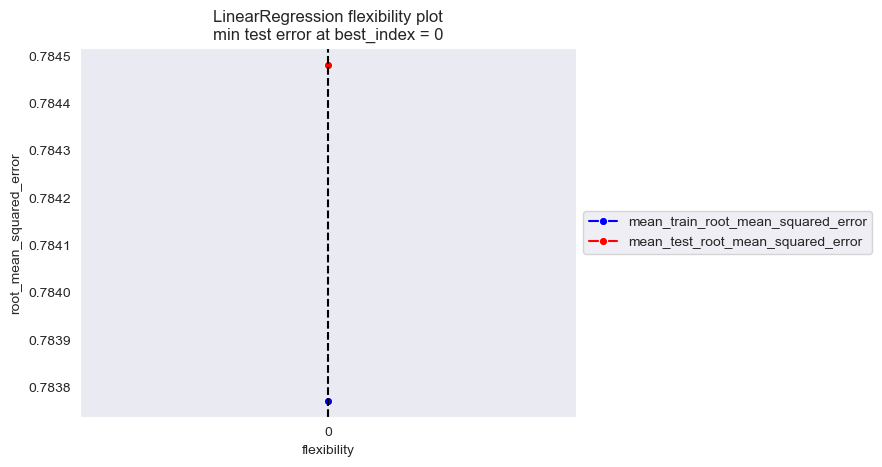

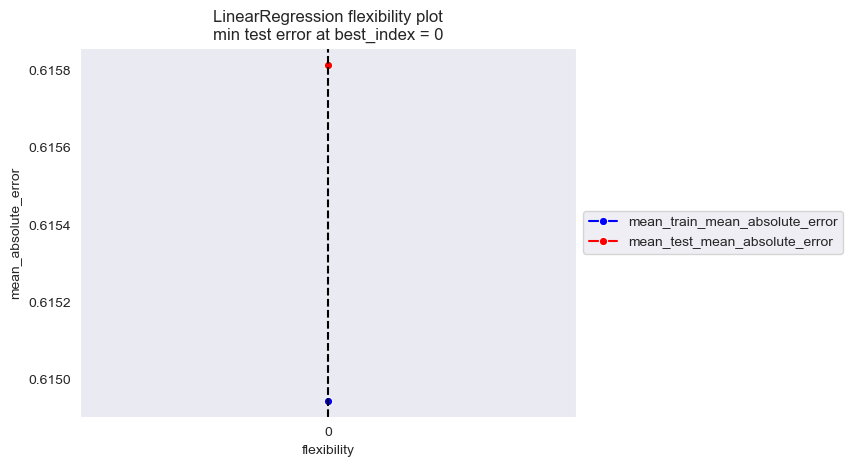

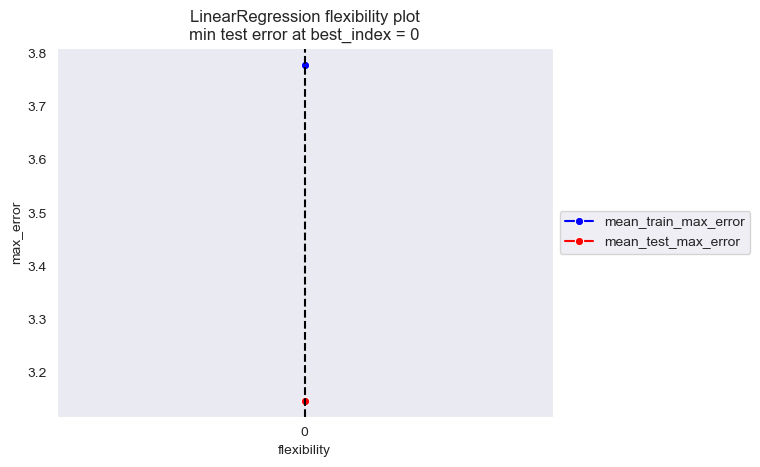

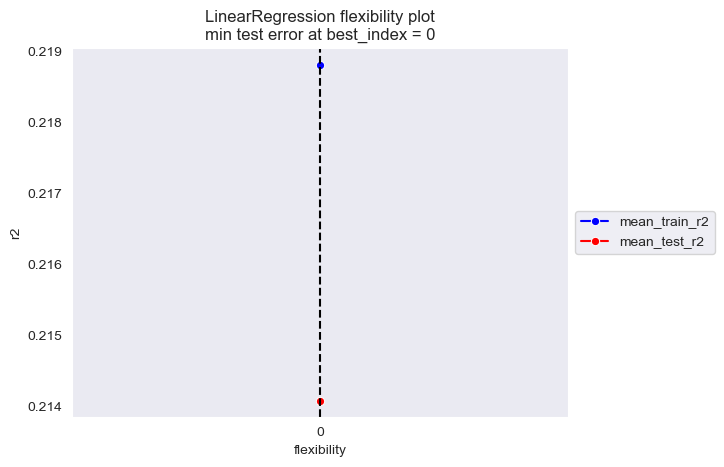

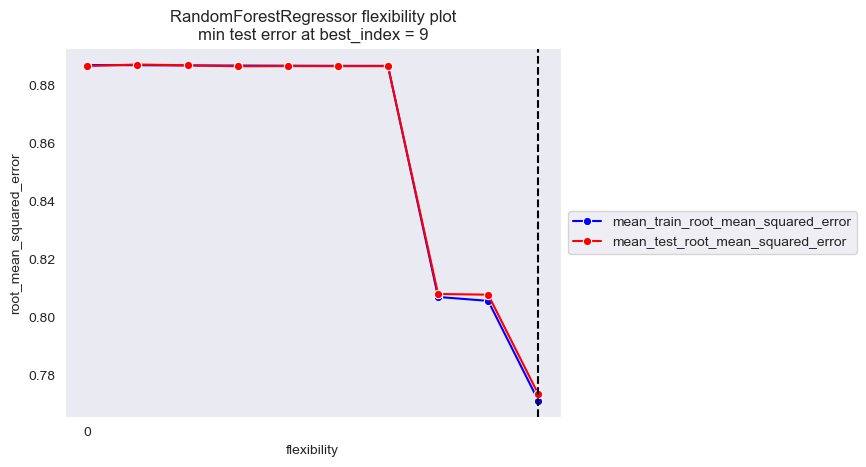

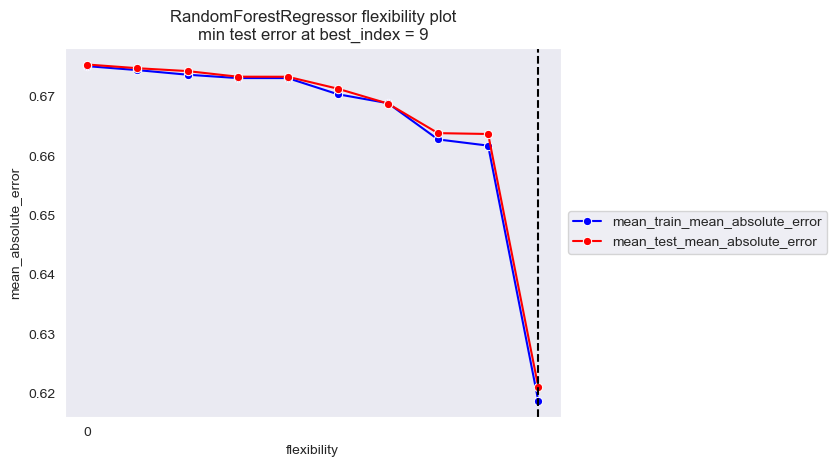

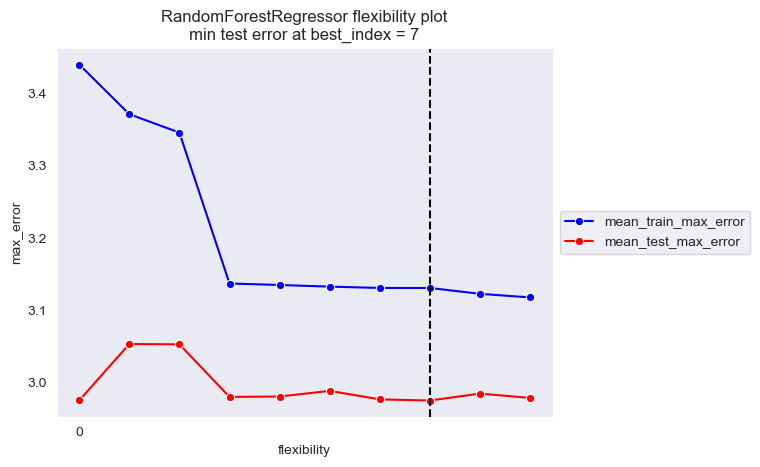

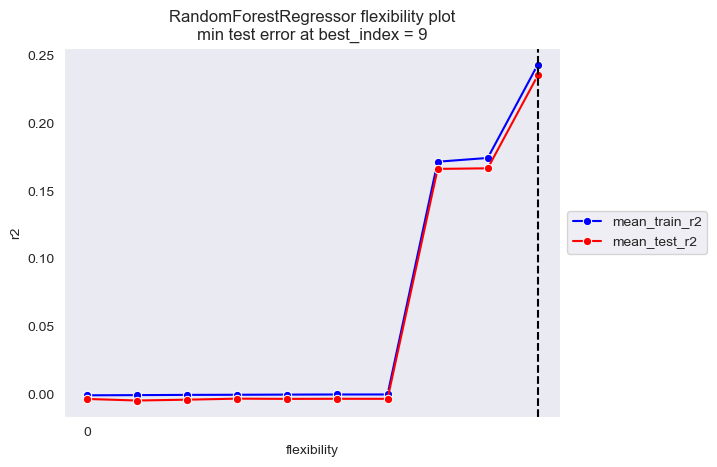

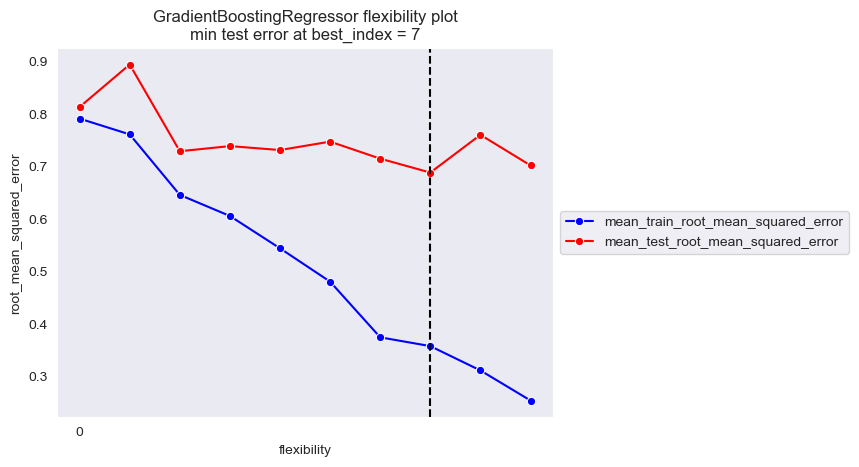

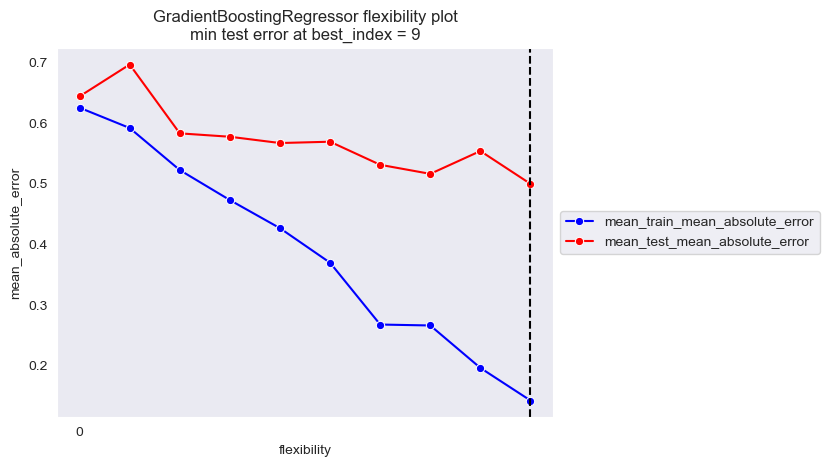

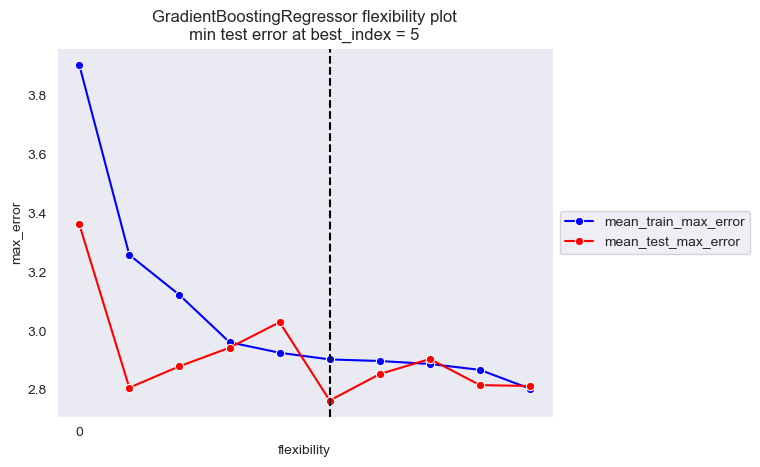

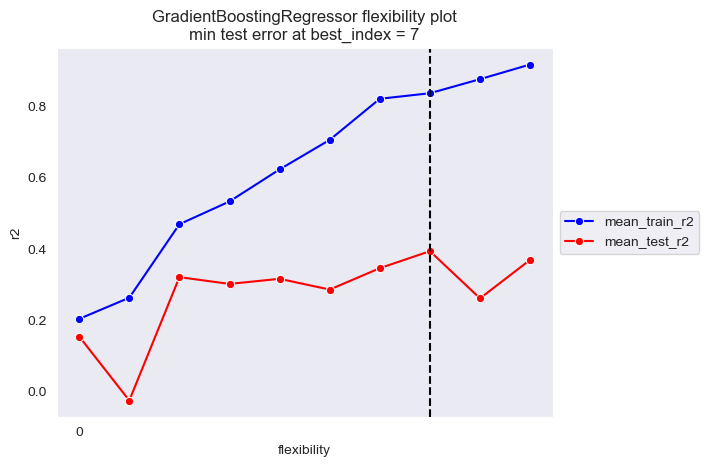

,estimator_name,score,best_test_score,best_index,grid_search_cv,gs_cv_results_df
0,GradientBoostingRegressor,max_error,2.763344,5,"RandomizedSearchCV(cv=KFold(n_splits=10, rando...",index rank_test_max_error mean_train_max_...
1,RandomForestRegressor,max_error,2.975212,7,"RandomizedSearchCV(cv=KFold(n_splits=10, rando...",index rank_test_max_error mean_train_max_...
2,LinearRegression,max_error,3.147617,0,"RandomizedSearchCV(cv=KFold(n_splits=10, rando...",index rank_test_max_error mean_train_max_...
3,GradientBoostingRegressor,neg_mean_absolute_error,0.499882,9,"RandomizedSearchCV(cv=KFold(n_splits=10, rando...",index rank_test_neg_mean_absolute_error \...
4,LinearRegression,neg_mean_absolute_error,0.615816,0,"RandomizedSearchCV(cv=KFold(n_splits=10, rando...",index rank_test_neg_mean_absolute_error \...
5,RandomForestRegressor,neg_mean_absolute_error,0.621116,9,"RandomizedSearchCV(cv=KFold(n_splits=10, rando...",index rank_test_neg_mean_absolute_error \...
6,GradientBoostingRegressor,neg_root_mean_squared_error,0.688356,7,"RandomizedSearchCV(cv=KFold(n_splits=10, rando...",index rank_test_neg_root_mean_squared_erro...
7,RandomForestRegressor,neg_root_mean_squared_error,0.773623,9,"RandomizedSearchCV(cv=KFold(n_splits=10, rando...",index rank_test_neg_root_mean_squared_erro...
8,LinearRegression,neg_root_mean_squared_error,0.784482,0,"RandomizedSearchCV(cv=KFold(n_splits=10, rando...",index rank_test_neg_root_mean_squared_erro...
9,LinearRegression,r2,0.214086,0,"RandomizedSearchCV(cv=KFold(n_splits=10, rando...",index rank_test_r2 mean_train_r2 std_tra...


In [306]:
gs_survey_results_df = pd.DataFrame()
for estimator_name, random_search_cv in tuned_estimator_dict.items():
    print('\n\n')
    return_dict = sml_utils.plot_flexibility(
        grid_search_cv=random_search_cv,
        estimator_name=estimator_name,
        scoring=scoring
    )
    results_df = return_dict['results_df']
    results_df['estimator_name'] = estimator_name
    results_df = results_df[['estimator_name'] + [attr for attr in results_df if attr not in ['estimator_name']]]
    gs_survey_results_df = pd.concat([gs_survey_results_df, results_df], axis=0)

gs_survey_results_df = gs_survey_results_df.sort_values(['score', 'best_test_score'])
gs_survey_results_df = gs_survey_results_df.reset_index(drop=True)
gs_survey_results_df

### Looking at best hyperparameters:

In [307]:
print('best hyperparameters for each estimator\n')

for estimator in tuned_estimator_dict.keys():
    print(estimator)
    print("Best estimator params:", tuned_estimator_dict[estimator].best_params_)

best hyperparameters for each estimator

LinearRegression
Best estimator params: {}
RandomForestRegressor
Best estimator params: {'estimator__max_depth': 110, 'estimator__max_leaf_nodes': 83, 'estimator__max_samples': 735, 'estimator__min_samples_leaf': 71, 'estimator__min_samples_split': 12, 'estimator__n_estimators': 8}
GradientBoostingRegressor
Best estimator params: {'estimator__learning_rate': 0.03129540073710562, 'estimator__max_depth': 10, 'estimator__max_features': 6, 'estimator__n_estimators': 163, 'estimator__n_iter_no_change': 302, 'estimator__subsample': 0.5412445685519647}


In [308]:
# min test score from GridSeachCV
min_test_score = gs_survey_results_df.best_test_score.min()
print(f'\nMinimum test score from RandomSearchCV: {min_test_score}')

# name of estimator with the min test score
estimator_name = gs_survey_results_df.loc[gs_survey_results_df['best_test_score'] == min_test_score, 'estimator_name'].iloc[0]
print(f'\nThe estimator with minimum test score from RandomSearchCV is considered the best model. It is: {estimator_name}')

# best estimator
best_model = gs_survey_results_df.loc[gs_survey_results_df['best_test_score'] == min_test_score, 'grid_search_cv'].values[0].best_estimator_


Minimum test score from RandomSearchCV: 0.21408571983541114

The estimator with minimum test score from RandomSearchCV is considered the best model. It is: LinearRegression


### using cross validation for model selection


                regressor_name              score_name_ score_type     score
0   GradientBoostingRegressor                max_error       test  2.838208
1   GradientBoostingRegressor                max_error      train  3.134840
2   GradientBoostingRegressor      mean_absolute_error       test  0.514565
3   GradientBoostingRegressor      mean_absolute_error      train  0.265212
4   GradientBoostingRegressor                       r2       test  0.397035
5   GradientBoostingRegressor                       r2      train  0.835328
6   GradientBoostingRegressor  root_mean_squared_error       test  0.686740
7   GradientBoostingRegressor  root_mean_squared_error      train  0.359839
8            LinearRegression                max_error       test  3.076218
9            LinearRegression                max_error      train  3.776253
10           LinearRegression      mean_absolute_error       test  0.615710
11           LinearRegression      mean_absolute_error      train  0.614959
12        

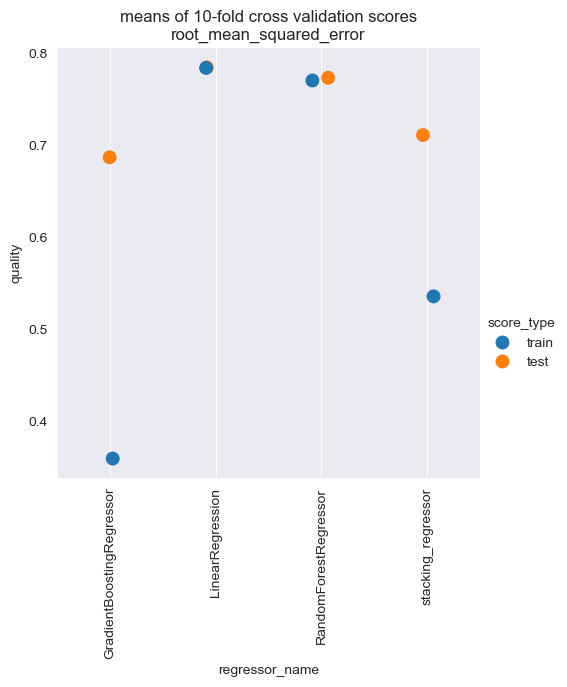

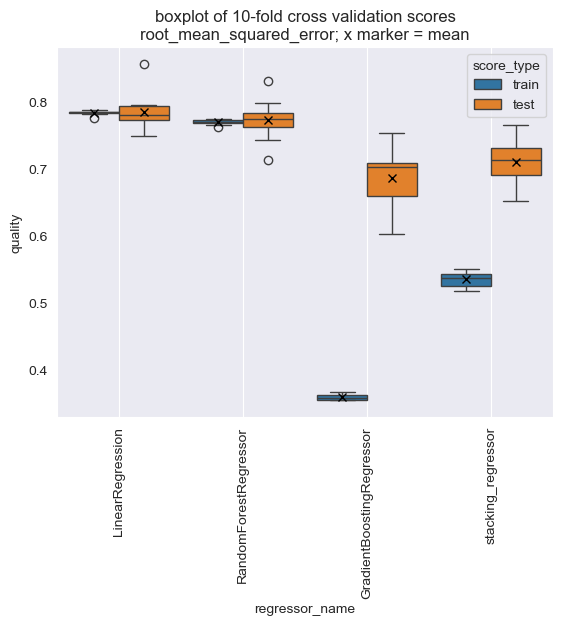

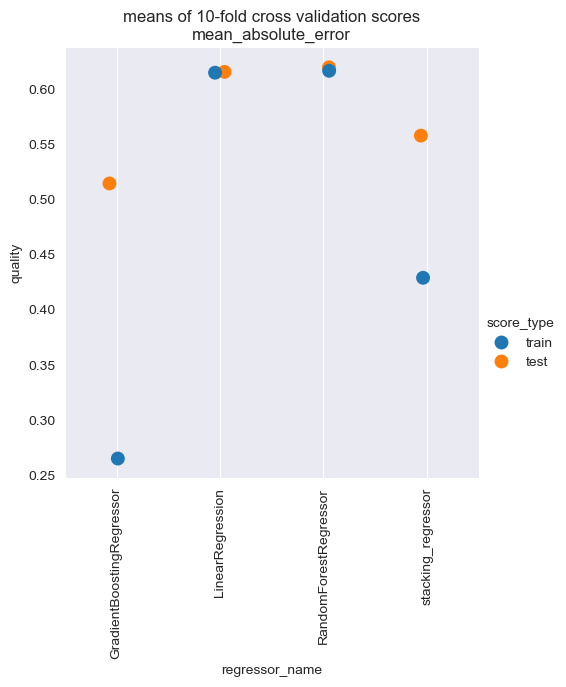

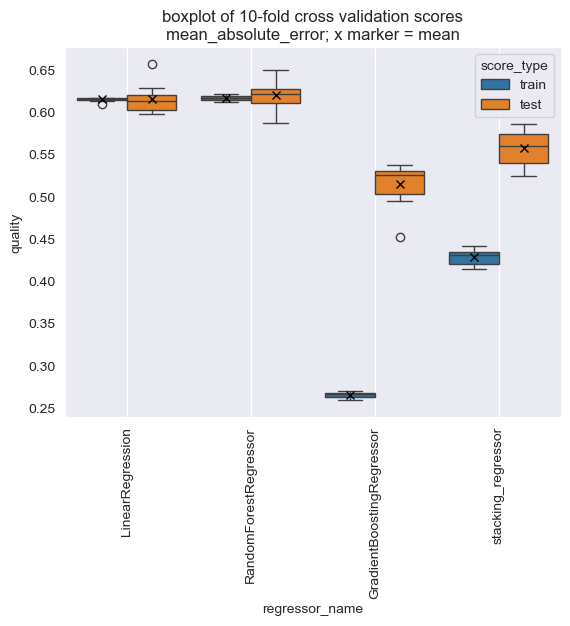

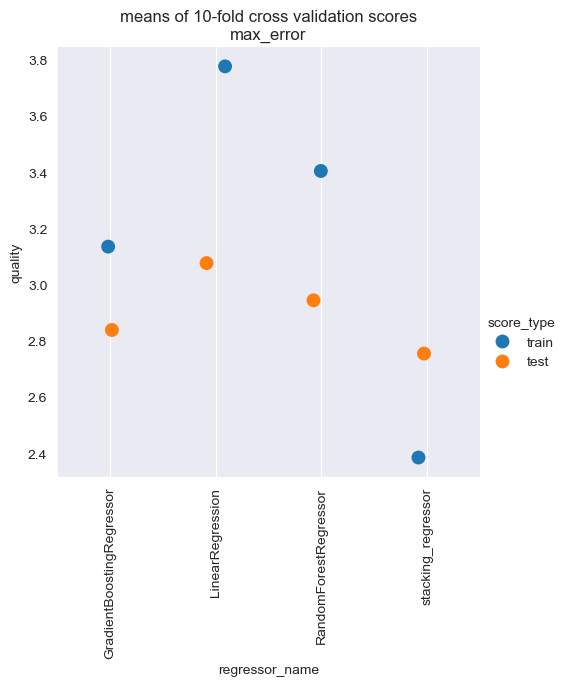

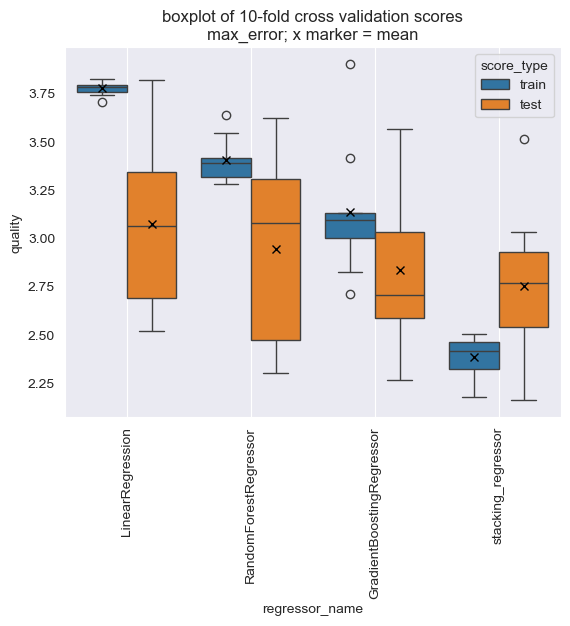

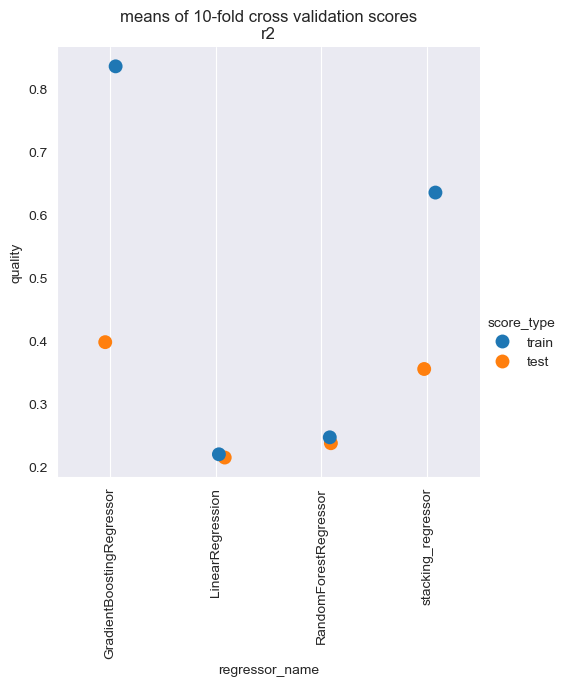

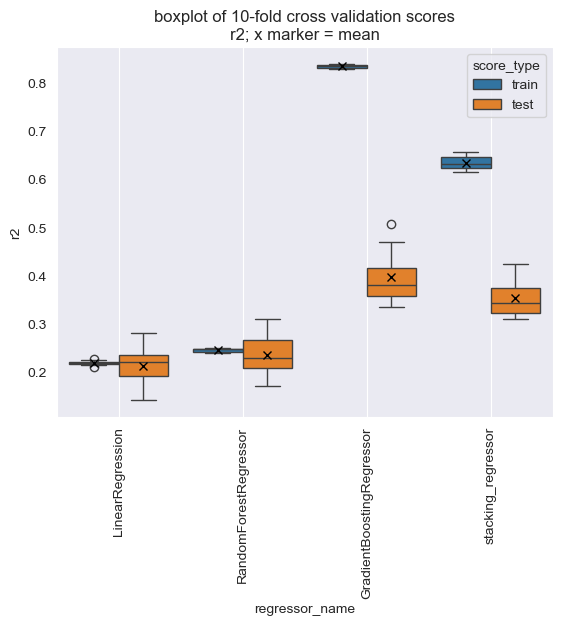

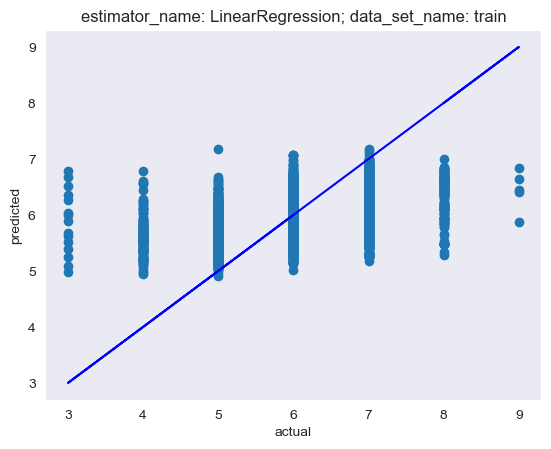

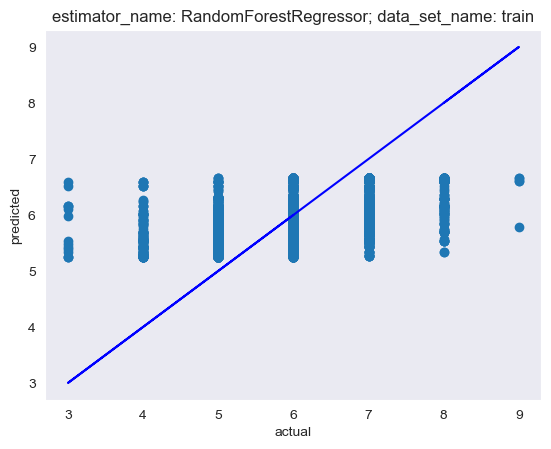

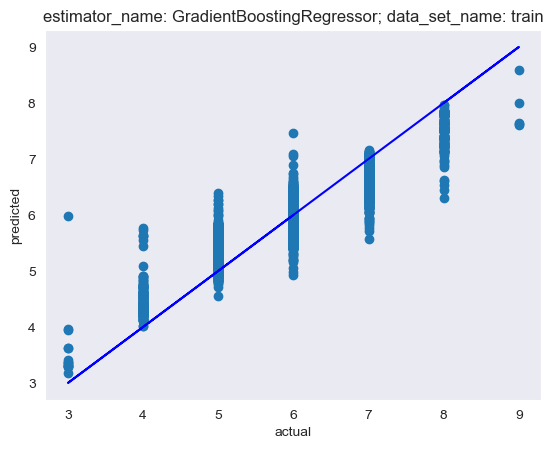

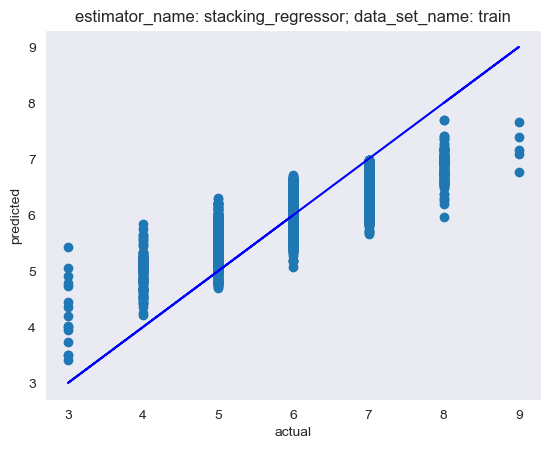

In [309]:
# get the maximal control k-fold cross validation splitter
splitter = KFold(n_splits=kfold_n_splits, 
                 shuffle=kfold_shuffle, 
                 random_state=kfold_random_state
)

stacking_regressor = StackingRegressor(
    estimators=[
        ("Decision Tree", trained_estimator_dict["DecisionTreeRegressor"]),
        ("Linear Regression", trained_estimator_dict["LinearRegression"]),
        ("Gradient Boosting", trained_estimator_dict["GradientBoostingRegressor"]),
    ]
)
tuned_estimator_dict_with_stacking = tuned_estimator_dict.copy()
tuned_estimator_dict_with_stacking['stacking_regressor'] = stacking_regressor.fit(train_cap_x_df, train_y_df.values.ravel())

# perform cross validation on models
sml_utils.model_tuning_cross_val_and_analysis(tuned_estimator_dict_with_stacking, train_cap_x_df, train_y_df, scoring, splitter, target_attr)

## 13. Evaluating the tuned composite estimators

In [310]:
rmse_best_model_on_train_set = root_mean_squared_error(train_y_df, best_model.predict(train_cap_x_df))
rmse_best_model_on_train_set
print(f'best_model is the trained estimator that performed the best in RandomSearchCV.\n'
      f'\nIt was trained on the whole train set using the hyperparameter combination\n'
      f'that gave the lowest estimate of test error rate in cross validation.\n'
      f'\nThe rmse of the best_model from the RandomSearchCV when prediction on the whole train set is {rmse_best_model_on_train_set}. Note, this does not include stacking, which is the model actually chosen later.')

best_model is the trained estimator that performed the best in RandomSearchCV.

It was trained on the whole train set using the hyperparameter combination
that gave the lowest estimate of test error rate in cross validation.

The rmse of the best_model from the RandomSearchCV when prediction on the whole train set is 0.78383226642309. Note, this does not include stacking, which is the model actually chosen later.


## 14. Check for false discoveries
Shuffling the target and using cross validation to see if the discoveries are real or just random chance.


                regressor_name              score_name_ score_type     score
0   GradientBoostingRegressor                max_error       test  3.171921
1   GradientBoostingRegressor                max_error      train  2.994933
2   GradientBoostingRegressor      mean_absolute_error       test  0.742599
3   GradientBoostingRegressor      mean_absolute_error      train  0.449761
4   GradientBoostingRegressor                       r2       test  0.154239
5   GradientBoostingRegressor                       r2      train  0.548563
6   GradientBoostingRegressor  root_mean_squared_error       test  0.951886
7   GradientBoostingRegressor  root_mean_squared_error      train  0.595785
8            LinearRegression                max_error       test  2.869985
9            LinearRegression                max_error      train  3.169313
10           LinearRegression      mean_absolute_error       test  0.672928
11           LinearRegression      mean_absolute_error      train  0.672090
12        

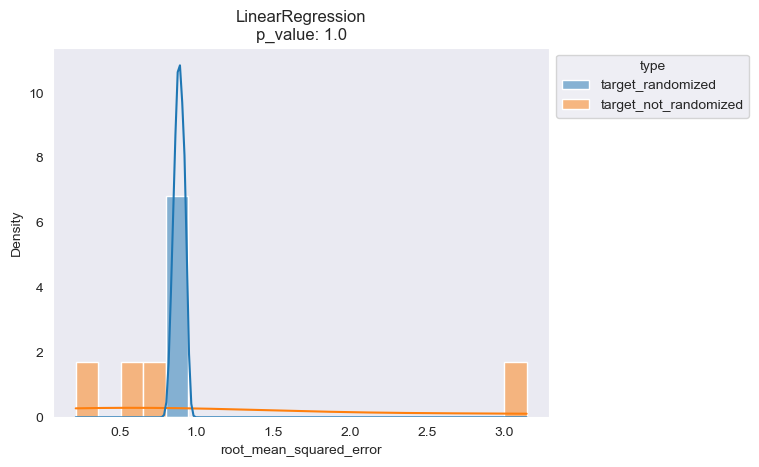

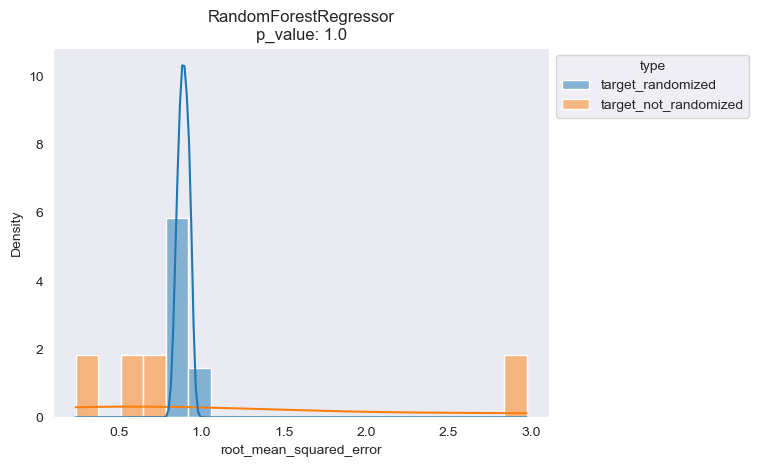

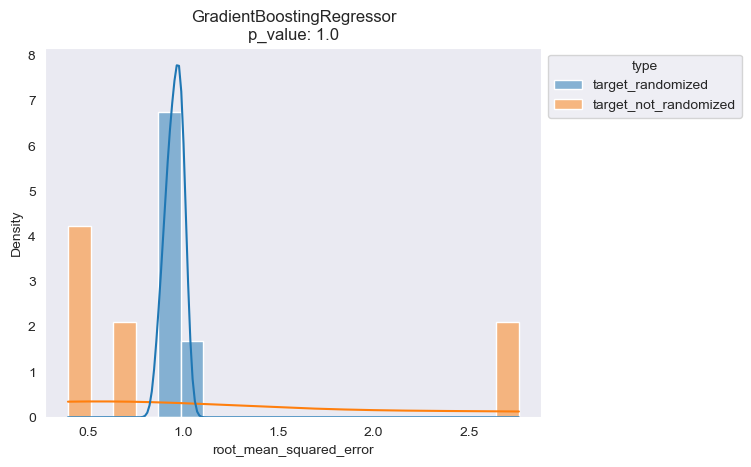

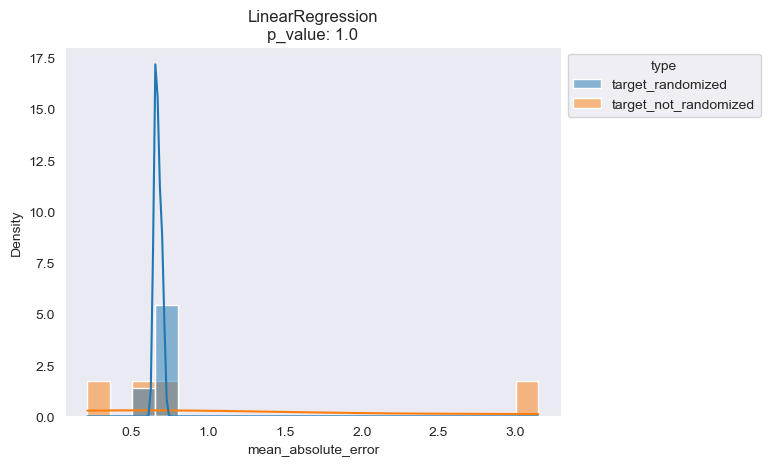

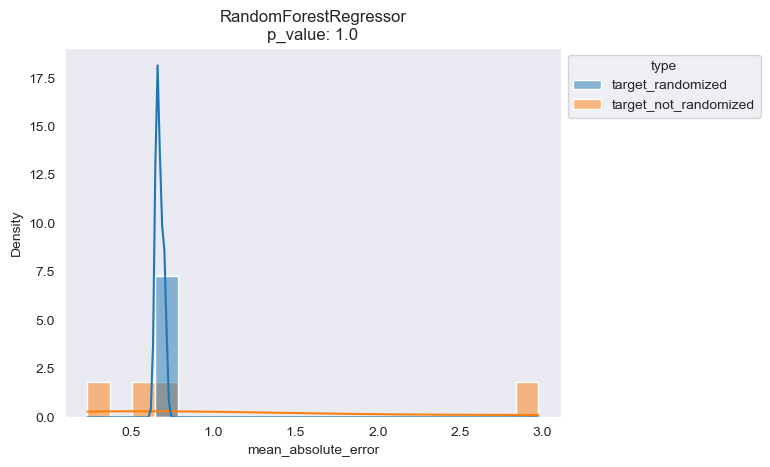

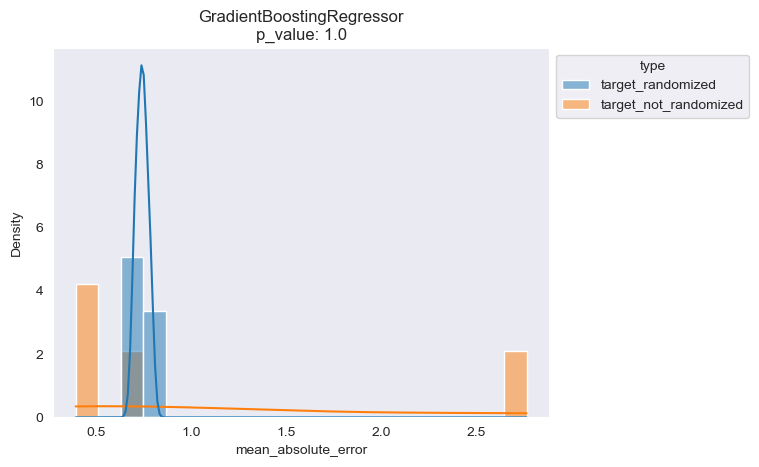

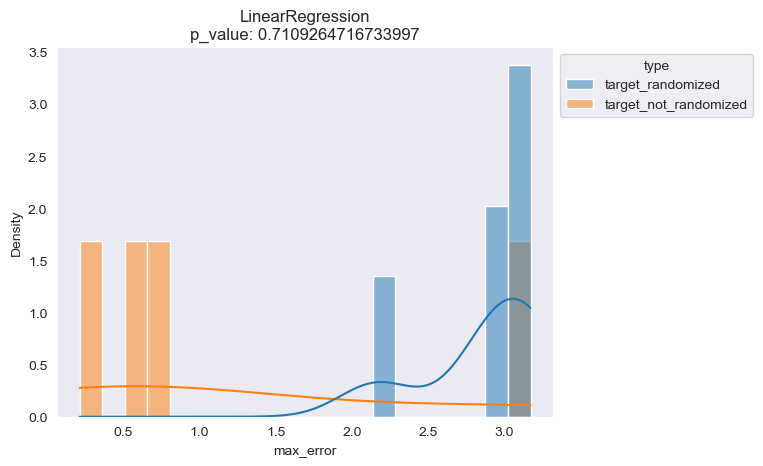

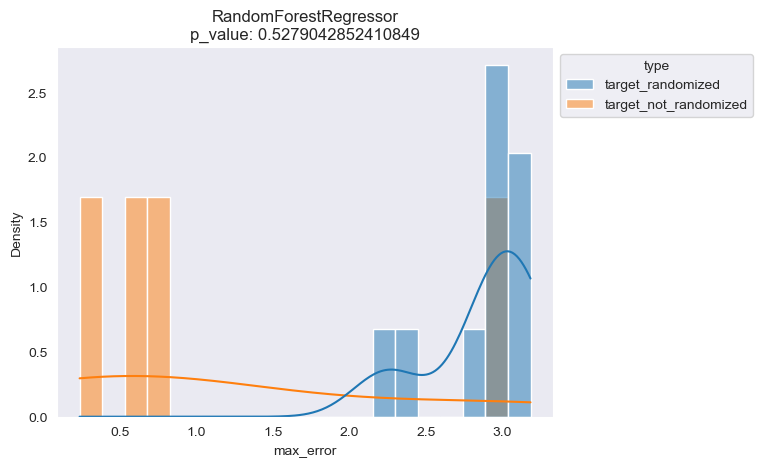

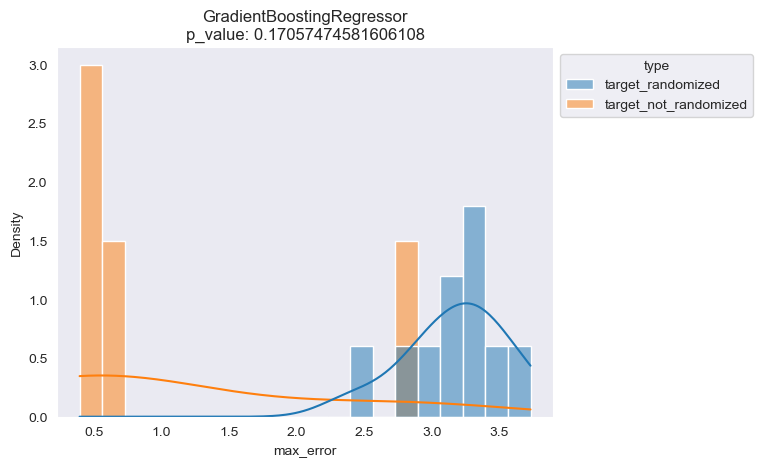

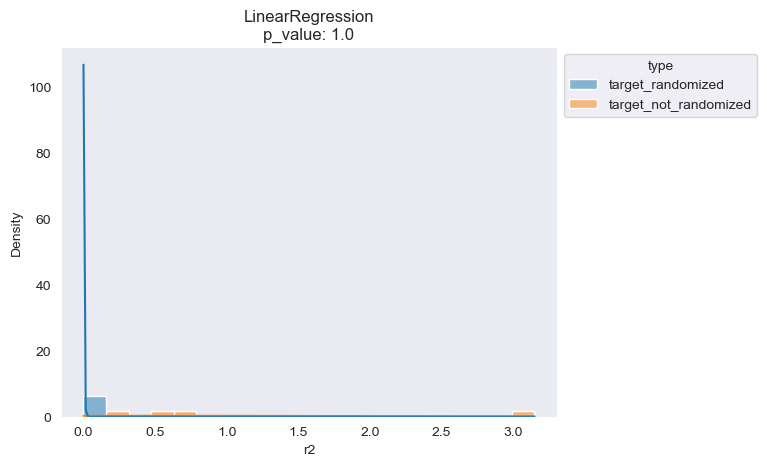

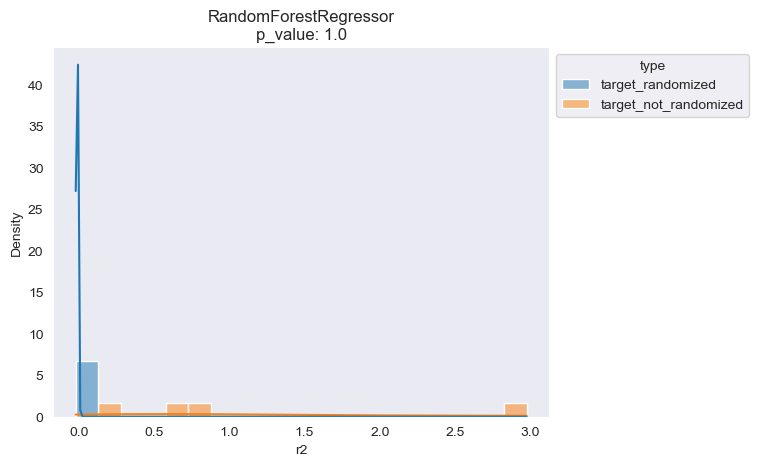

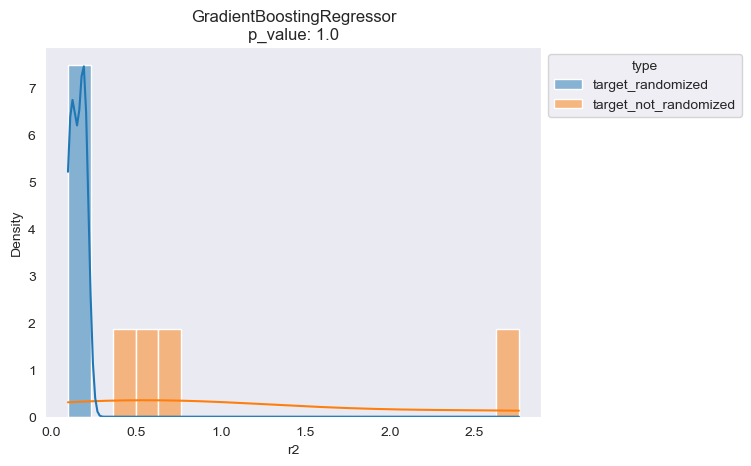

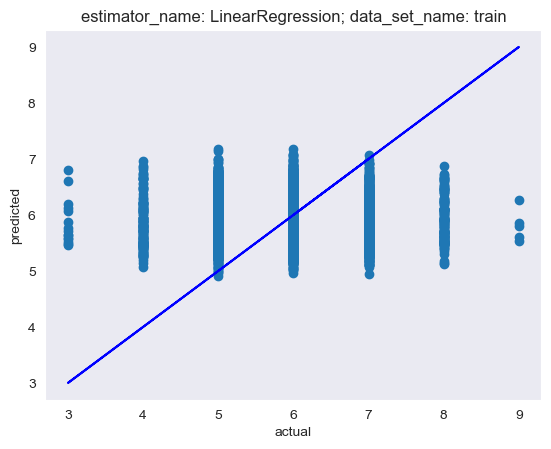

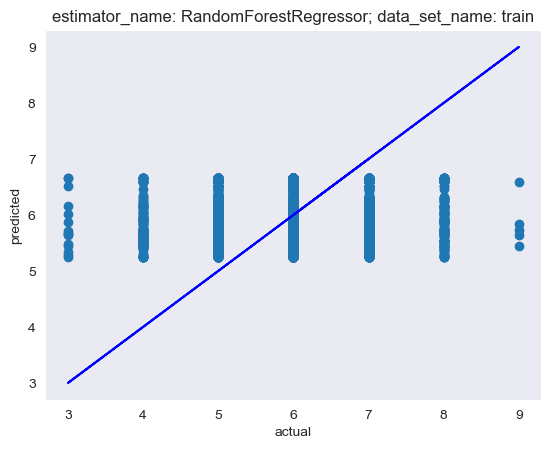

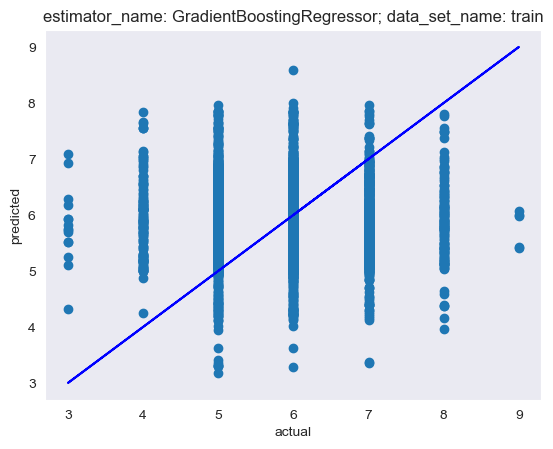

In [311]:
sml_utils.check_for_false_discoveries(tuned_estimator_dict, train_cap_x_df, train_y_df, scoring, splitter, target_attr, shuffle_target=True,
                                      shuffle_target_random_state=42, gs_survey_results_df=gs_survey_results_df)

## 15. Selecting our model

In [312]:
composite_estimator = tuned_estimator_dict_with_stacking['stacking_regressor']  # using stacking regressor ensemble method

## 16. Evaluating generalization/making predictions on the test set with our model

In [313]:
if composite_estimator is None:
    sys.exit('no model was selected')

In [314]:
test_df = pd.read_csv('data/wine_test_df.csv')
test_df.index.name = None
test_df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,6.0,0.29,0.41,10.8,0.048,55.0,149.0,0.99370,3.09,0.59,10.966667,7
1,5.4,0.53,0.16,2.7,0.036,34.0,128.0,0.98856,3.20,0.53,13.200000,8
2,7.1,0.25,0.39,2.1,0.036,30.0,124.0,0.99080,3.28,0.43,12.200000,8
3,7.3,0.28,0.35,1.6,0.054,31.0,148.0,0.99178,3.18,0.47,10.700000,5
4,6.5,0.32,0.34,5.7,0.044,27.0,91.0,0.99184,3.28,0.60,12.000000,7


In [315]:
test_cap_x_df = test_df.iloc[:, :-1]
test_cap_x_df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
0,6.0,0.29,0.41,10.8,0.048,55.0,149.0,0.99370,3.09,0.59,10.966667
1,5.4,0.53,0.16,2.7,0.036,34.0,128.0,0.98856,3.20,0.53,13.200000
2,7.1,0.25,0.39,2.1,0.036,30.0,124.0,0.99080,3.28,0.43,12.200000
3,7.3,0.28,0.35,1.6,0.054,31.0,148.0,0.99178,3.18,0.47,10.700000
4,6.5,0.32,0.34,5.7,0.044,27.0,91.0,0.99184,3.28,0.60,12.000000


In [316]:
test_y_df = test_df.iloc[:, -1].to_frame()
test_y_df.head()

,quality
0,7
1,8
2,8
3,5
4,7


In [317]:
del test_df

## Scores

In [318]:
test_rmse = root_mean_squared_error(test_y_df, composite_estimator.predict(test_cap_x_df))
print(f'test_rmse: {test_rmse}')
print(f'relative test_rmse: {test_rmse/np.mean(test_y_df)}')

test_rmse: 0.686145440579456
relative test_rmse: 0.11621543929620928


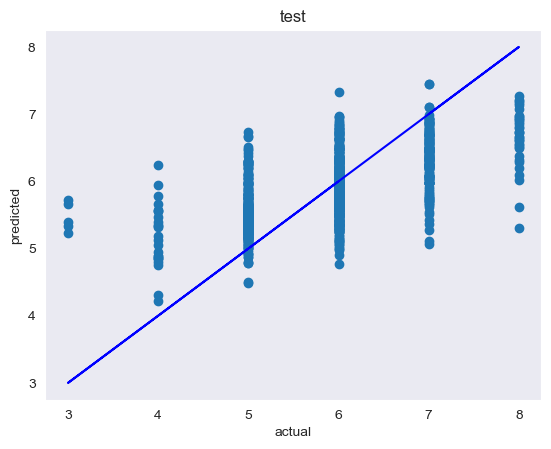

In [319]:
pred_y_df = composite_estimator.predict(test_cap_x_df)
data_set_name = 'test'
reg_utils.plot_pred_vs_actual(pred_y_df, test_y_df, data_set_name)

## Script run time

In [320]:
end = time.time()
print(f'script run time: {(end - start)/60} minutes')

script run time: 0.9841562310854594 minutes
